In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Comment out if not using scienceplots
import scienceplots
plt.style.use(['science', 'grid'])
plt.rcParams['text.latex.preamble'] = r'''
    \usepackage[T1]{fontenc}
    \usepackage{XCharter}
    \usepackage[charter,vvarbb,scaled=1.05]{newtxmath}
'''

plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["figure.dpi"] = 150

from scipy.spatial.transform import Rotation as R

In [4]:
# Physical constants
mu = 3.9860044188e14 # mu = GM, https://en.wikipedia.org/wiki/Standard_gravitational_parameter
R_E = 6378 # radius of Earth

# Coordinate frame
i = np.array([1, 0, 0])
j = np.array([0, 1, 0])
k = np.array([0, 0, 1])

In [5]:
# Calculate the full field of view (FOV) from a full swath given the satellite altitude.
def fov_from_swath(swath, h):
    # Earth subtending angle
    theta =  swath / R_E

    # compute length from end of swath to satellite using the Law of Cosines
    tangent_length = np.sqrt(R_E**2 + (R_E + h)**2 - 2*R_E*(R_E + h)*np.cos(theta/2))
    
    # compute fov using the Law of Sines
    alfa = 2* np.arcsin(np.sin(theta/2) * ((R_E) / tangent_length))

    return alfa

# This is a half FOV and half-angle
def subtending_angle_from_fov(fov, h):
    sign = np.sign(fov)
    angle = np.abs(fov)
    
    beta = np.pi - np.arcsin((R_E + h)/(R_E) * np.sin(angle)) # obtuse angle
    
    theta = np.pi - (angle + beta)
    return theta * sign

def swath_from_fov(angle, h):
    return subtending_angle_from_fov(angle, h) * R_E
    
# Convert Euler angles (roll, pitch, yaw) to a Direction Cosine Matrix (DCM).
def eul2dcm(roll, pitch, yaw):
    # create rotation matrices for each individual axis
    R_x = np.array([[1,         0,                  0                   ],
                    [0,         np.cos(roll), -np.sin(roll) ],
                    [0,         np.sin(roll),  np.cos(roll) ]
                    ])
    
    R_y = np.array([[np.cos(pitch),    0,      np.sin(pitch) ],
                    [0,                         1,      0                   ],
                    [-np.sin(pitch),   0,      np.cos(pitch) ]
                    ])
                
    R_z = np.array([[np.cos(yaw),    -np.sin(yaw),    0],
                    [np.sin(yaw),     np.cos(yaw),    0],
                    [0,                        0,                       1]
                    ])
    
    # combine rotations in a yaw-pitch-roll sequence
    dcm = np.dot(R_z, np.dot( R_y, R_x ))
    
    return dcm

# Generate a square pattern of points with equal spacing.
def square_points(n=1):
    if n == 1:
        return np.array([[1, 1], [1, -1], [-1, 1], [-1, -1]])
    
    # Generate linearly spaced values between -1 and 1
    vals = np.linspace(-1, 1, n)
    
    # Top and bottom sides
    top = np.column_stack((vals, np.ones(n)))
    bottom = np.column_stack((vals, -np.ones(n)))
    
    # Left and right sides without repeating corners
    left = np.column_stack((-np.ones(n-2), vals[1:-1]))
    right = np.column_stack((np.ones(n-2), vals[1:-1]))
    
    return np.vstack((top, bottom, left, right))

# Compute the corner vectors of a camera given the FOV in the x and y directions and the camera's direction vector.
# The function can oversample the vectors for higher precision.
def camera_corner_vectors(fov_x, fov_y, r_c, oversample=1):
    # from top left going clockwise
    i_c, j_c, k_c = [r_c[:,x] for x in range(3)]
    square_sample_points = square_points(oversample)
    return [(i_c) + (x * np.sin(fov_x/2) * j_c) + (y * np.sin(fov_y/2) * k_c) for x,y in square_sample_points]
    
# Determine the intersection of a ray (represented by a starting point P and a direction vector u) with Earth's surface.
def earth_line_intersection(P, u):  
    # compute coefficients for the quadratic equation
    a = np.dot(u, u)
    b = 2 * np.dot(u, P)
    c = np.dot(P, P) - R_E**2
    
    # Cclculate the discriminant
    discriminant = b**2 - 4*a*c
    
    # if discriminant is negative, no intersection
    if discriminant < 0:
        return None
    
    # calcualte closest intersection only
    t0 = (-b - np.sqrt(discriminant)) / (2*a)
    # print(P)
    return P + t0*u

def sort_points_clockwise(data):
    # Convert the data to numpy arrays
    points = np.array(data).T  # Transpose to get points as (x, y)
    
    # Calculate the centroid of the points
    centroid = np.mean(points, axis=0)
    
    # Calculate the angles of each point with respect to the centroid
    deltas = points - centroid
    angles = np.arctan2(deltas[:, 1], deltas[:, 0])
    
    # Sort the points based on their angles
    sorted_points = points[np.argsort(angles)]
    
    return sorted_points.T  # Transpose back to get two arrays (x-coordinates and y-coordinates)
    
# Normalize a vector to make it a unit vector.
def unit_vector(v):
    return v / np.linalg.norm(v)

# Calculate the directed angle between two vectors.
def angle_between(v1, v2):
    # Normalize the vectors
    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)
    
    # Compute the dot product
    dot = np.dot(v1, v2)
    
    # Compute the cross product
    cross = np.cross(v1, v2)
    
    # Compute the magnitude of the cross product
    cross_magnitude = np.linalg.norm(cross)
    
    # Compute the angle using arctan2
    angle = np.arctan2(cross_magnitude, dot)
    
    # Determine the direction of the angle. If the cross product's z-component is negative, then the angle is negative.
    if cross[2] < 0:
        angle = -angle

    return angle
    
# Calculate the angle between vectors, with vectors represented as rows in a matrix
def angle_between_vectorized(v1, v2):
    return np.array([angle_between(x, y) for x, y in zip(v1, v2)])

# Convert Cartesian coordinates to spherical coordinates.
def cartesian_to_spherical(u):
    r = np.linalg.norm(u)
    
    x       = u[0]
    y       = u[1]
    z       = u[2] 
    
    theta   =  np.arccos(z/r)
    phi     =  np.arctan2(y,x)
    
    return np.array([r,theta,phi])

# Convert a list of Cartesian coordinates to spherical coordinates.
def cartesian_to_spherical_vectorized(u):
     return np.array([cartesian_to_spherical(x) for x in u])
    
# Convert spherical coordinates to Cartesian coordinates.
def spherical_to_cartesian(u):
    r = u[:, 0]
    theta = u[:, 1]
    phi = u[:, 2]
    
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    
    return (np.stack((x, y, z)).T)

# Project a spherical coordinate onto the along/across track, considering the height h of the satellite.
def spherical_to_track(h, v):
    # Input projected vector
    # along_track = v[:, 1] * R_E
    def find_projected_point(h, v):
        # project onto xz plane at orbit altitude
        u = v.copy()
        # project into xz plane..
        u = spherical_to_cartesian(u)
        
        u[:,1] = 0
        
        u = cartesian_to_spherical_vectorized(u)
        # radius max
        u[:,0] = R_E + h
        
        return spherical_to_cartesian(u)

    def project_along_track(v):
        # project onto xz plane at orbit altitude
        u = v.copy()
        # project into xz plane..
        u = spherical_to_cartesian(u)
        u[:,1] = 0 # set y = 0 to project into xz plane

        u = cartesian_to_spherical_vectorized(u)
   
        return u[:,1] * np.cos(u[:,2]) * R_E

    along_track = project_along_track(v)
    
    spacecraft_projected_track = find_projected_point(h,v)
    earth_point_to_propagated_spacecraft = spacecraft_projected_track - spherical_to_cartesian(v)
    across_track_angle = angle_between_vectorized(spacecraft_projected_track, earth_point_to_propagated_spacecraft)
    across_track_km = swath_from_fov(across_track_angle, h)
    # across_track_km = v[:, 2] * R_E
    return np.stack((across_track_km, along_track))

# Calculate lookahead time for an angular lookahead
def calc_lookahead_time(angle, h):
    thetadot = np.sqrt(mu / (((R_E+h)*1e3) ** 3)) # Angular motion over Earth
    max_angle = np.arcsin(R_E / (R_E+h))
    
    if(angle > max_angle):
        angle = max_angle - 1e-9
        
    lookahead_subtending_angle = subtending_angle_from_fov(angle, h) 

    return lookahead_subtending_angle / thetadot 
        

In [6]:
h = 500 # orbit altitude
boresight_lookahead = 40 # degrees

pixels_x = 4000
pixels_y = 1

fov_x = fov_from_swath(19.4, h)
print(f"Fov width: {np.rad2deg(fov_x)} degrees")
ifov_x = fov_x / pixels_x
fov_y = ifov_x # fov_x # single square pixel

# fov_x = 0.1
# fov_y = 0.1


Fov width: 2.2227637764847925 degrees


In [7]:
# Earth defined as O at origin with radius R_E
O = np.array([0, 0, 0])
# Spacecraft location
P = np.array([0, 0, R_E + h])

def calc_lookahead_track(fov_x, fov_y, boresight_lookahead, oversample=1):
    boresight_pitch = 90 - boresight_lookahead 
    # TODO: update this with body frame and rotors...
    # so we can do generalized geolocation
    
    # Assume nadir pointing and start with pitch only
    # Camera rotor represnting camera coordinate frame
    r_c = eul2dcm(0, np.deg2rad(boresight_pitch), 0)
    # i is rotated into boresight of the camera
    i_c, j_c, k_c = np.hsplit(r_c, 3)
    
    # Now calculate corner vectors
    corner_vectors = camera_corner_vectors(fov_x, fov_y, r_c, oversample=oversample)

    earth_intersection_cartesian = np.array([(earth_line_intersection(P, x)) for x in corner_vectors])
    earth_intersection_spherical = np.array([cartesian_to_spherical(x) for x in earth_intersection_cartesian])

    return spherical_to_track(h, earth_intersection_spherical)

def calc_pixel_gsd(lookahead):
    n = (lookahead.shape[1]+4)//4 
    pixel_gsd = np.zeros((2, n))
    
    top_left = n - 1
    bottom_right = 2 * n - 1

    for i in range(n):
        pixel_gsd[0, i] = 0.5 * (lookahead[0, top_left - i] + lookahead[0, bottom_right - i])
        pixel_gsd[1, i] = np.linalg.norm(lookahead[:, top_left - i] - lookahead[:, bottom_right - i])
        # print(f"Vertical pair: {lookahead[:, top_left - i]}, {lookahead[:, bottom_right - i]}, subtracted: {lookahead[:, top_left - i] - lookahead[:, bottom_right - i]}")
        
    return pixel_gsd


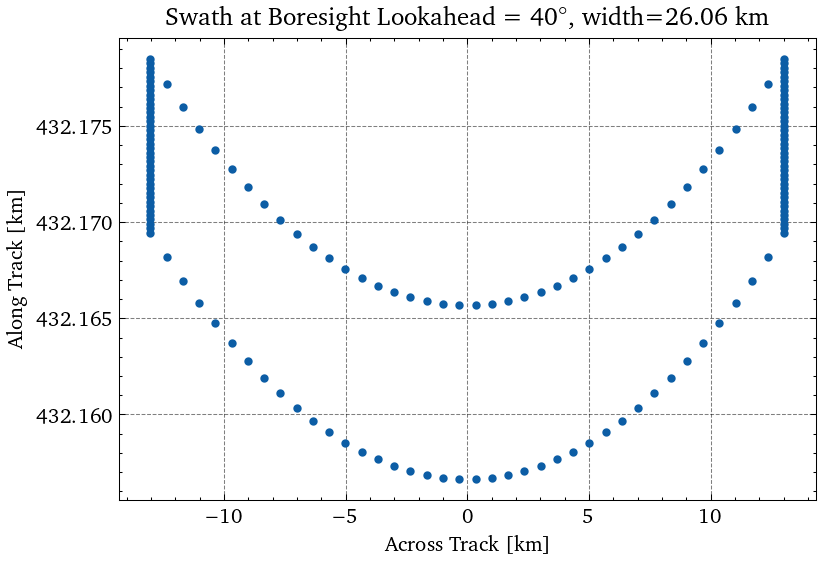

Swath width: 26.06175012027645


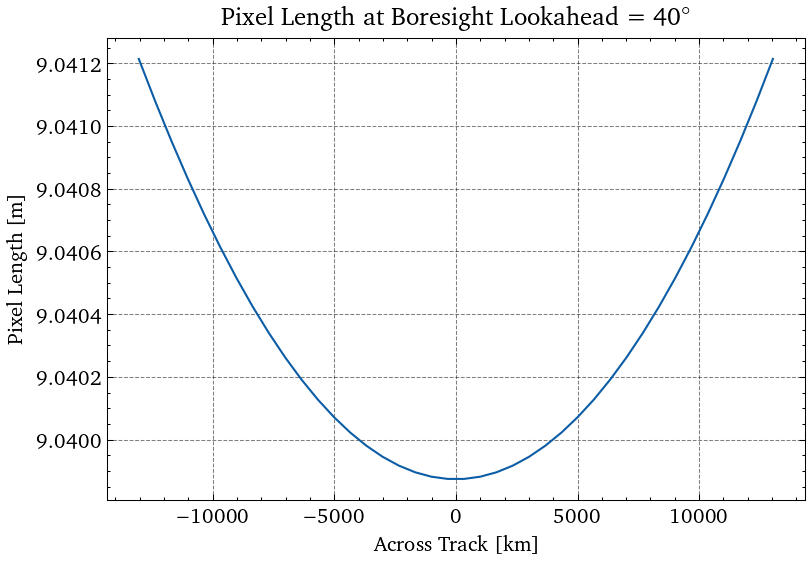

In [8]:
lookahead_track = calc_lookahead_track(fov_x, fov_y, boresight_lookahead, oversample=40)
pixel_gsd = calc_pixel_gsd(lookahead_track) * 1000 # in metres

plt.plot(lookahead_track[0, :], lookahead_track[1, :], '.')
# plt.plot(lookahead_track[0, :], lookahead_track[1, :] + 0.009, '.')
plt.gca().ticklabel_format(useOffset=False)

# sorted_ponts = sort_points_clockwise(lookahead_track)
# polygon = patches.Polygon(sorted_ponts.T, edgecolor='blue', facecolor='none')

# Get the current axes
ax = plt.gca()

# Add the patch to the axes
# ax.add_patch(polygon)
ax.autoscale_view()
# plt.plot(lookahead_track[0, :]/1e3, lookahead_track[1, :]/1e3, 'x')
# plt.axis('equal')
plt.xlabel("Across Track [km]")
plt.ylabel("Along Track [km]")
plt.title(f"Swath at Boresight Lookahead = {boresight_lookahead}$^\circ$, width={np.max(lookahead_track[0, :]) - np.min(lookahead_track[0, :]):.2f} km")
plt.savefig(f"swath_boresight_{boresight_lookahead:.1f}.png", dpi=300, facecolor='w')
plt.show()

print(f"Swath width: {np.max(lookahead_track[0, :]) - np.min(lookahead_track[0, :])}")

plt.plot(pixel_gsd[0, :], pixel_gsd[1, :])
plt.gca().ticklabel_format(useOffset=False)
plt.xlabel("Across Track [km]")
plt.ylabel("Pixel Length [m]")
plt.title(f"Pixel Length at Boresight Lookahead = {boresight_lookahead}$^\circ$")
plt.savefig(f"pixel_length_boresight_{boresight_lookahead:.1f}.png", dpi=300, facecolor='w')
plt.show()

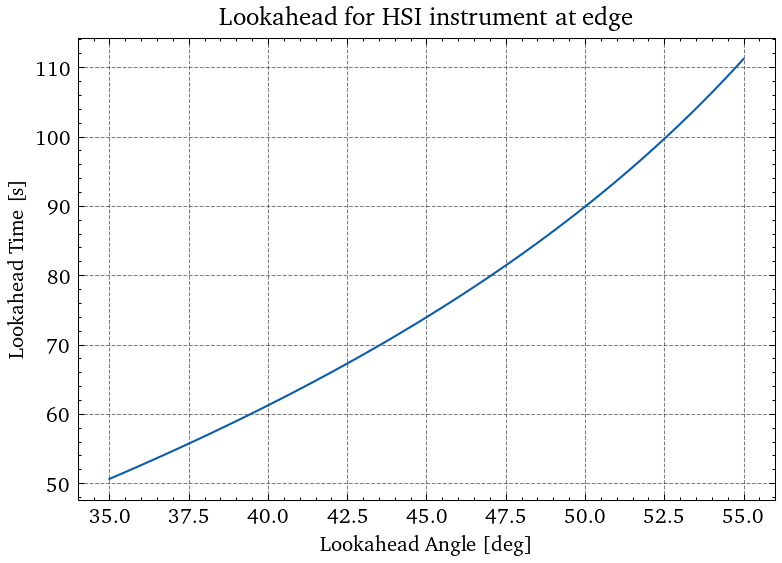

In [9]:
angle = np.deg2rad(np.linspace(35, 55, 100))
lookahead_time = [calc_lookahead_time(x, h) for x in angle]

plt.plot(np.rad2deg(angle), lookahead_time)
plt.xlabel("Lookahead Angle [deg]")
plt.ylabel("Lookahead Time [s]")
plt.title("Lookahead for HSI instrument at edge")
plt.savefig("lookahead_time_hsi.png", dpi=300, facecolor='w')
# plt.xlim(35)
# plt.ylim(0)
plt.show()

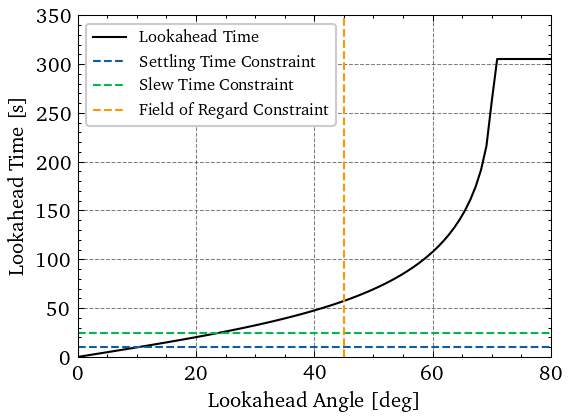

In [13]:
angle = np.deg2rad(np.linspace(0, 90, 100))
lookahead_time = [calc_lookahead_time(x, 400) for x in angle]

# First of all let's redo this for the case of a specific spacecraft...
# Use the cases from thesis..

# Ultra agile
# field_of_regard = 45
# t_s = 5
# t_slew = 15

# Agile
field_of_regard = 45
t_s = 10
t_slew = 25

plt.figure(figsize=(4,3), dpi=150)
plt.plot(np.rad2deg(angle), lookahead_time, 'k', label="Lookahead Time",)
plt.plot([0, 1000], [t_s, t_s], '--', label="Settling Time Constraint") # Freeze
plt.plot([0, 1000], [t_slew, t_slew], linestyle="dashed", label="Slew Time Constraint") # Slew time
plt.plot([field_of_regard, field_of_regard], [0, 1000], linestyle="dashed", label="Field of Regard Constraint") # Field of regard
plt.xlim((0, 80))
plt.ylim((0, 350))
plt.xlabel("Lookahead Angle [deg]")
plt.ylabel("Lookahead Time [s]")
plt.legend(fontsize=8)
plt.savefig("lookahead_time_constraints_agile.pdf")
# plt.xlim(35)
# plt.ylim(0)
plt.tight_layout()
plt.show()